<h2><center><font color=#D40004><u> Electric Power Consumption Forecasting  </u></font></center></h2>
<h3><center> Maria GALMAN, and NECHBA Mohammed</center></h3>
<br> 


# Goal of this Project
The primary goal of this project is to develop a robust model for forecasting electric power consumption in Tetouan, Morocco. Leveraging historical data and weather-related features, our objective is to create an accurate prediction tool that can assist in optimizing energy management within the city. By achieving this goal, we aim to enhance energy reliability, support data-driven decision-making in energy policy, and promote sustainable energy practices in Tetouan. This predictive model will empower us to proactively address energy demand fluctuations, particularly during extreme weather conditions, and contribute to the efficient allocation of electrical resources.

# Dataset
The data used in this notebook comes from the [Kaggle's Electric Power Consumption dataset](https://www.kaggle.com/datasets/fedesoriano/electric-power-consumption). This dataset is a CSV file with 3 columns of electric power consumption recorded at a frequency of 6 samples per hour (1 sample every 10 minutes). Each of these 3 columns represents a zone of the city of Tétouan, in Morocco.

**Features**:
* **Date Time**: Time window of ten minutes.
* **Temperature**: Weather Temperature.
* **Humidity**: Weather Humidity.
* **Wind Speed**: Wind Speed.
* **General Diffuse Flows**: “Diffuse flow” is a catchall term to describe low-temperature (< 0.2° to ~ 100°C) fluids that slowly discharge through sulfide mounds, fractured lava flows, and assemblages of bacterial mats and macrofauna.
* **Diffuse Flows**

**Target**:
*  **Zone 1 Power Consumption**
*  **Zone 2 Power Consumption**
*  **Zone 3 Power Consumption**

## <p style="background-color:skyblue; font-family:newtimeroman; font-size:120%; text-align:center">Table of Content</p>

* [I. Importing/Loading & checking the data](#1)
* [II. Data visualization 📊](#2)
* [III. Data Preprocessing ⚙️](#3)
    * [III.1 Handle Missings](#3.1)
    
* [IV. Feature engineering 🔧](#4)
* [V. Exploratory Data Analysis 📊](#5)
* [VI. Modeling](#5)
     * [ VI.1. Multilayer Perceptron model](#6.1)
     * [ VI.2. CNN model](#6.2)
     * [ VI.3. LSTM](#6.3)
     * [VI.4. Xgboost model](#6.4)
     * [VI.5. Comparing models](#6.5)
     
* [6. Conclusions](#7)
* [7. References](#8)

<a id='1'></a>
 # <p style="background-color:skyblue; font-family:newtimeroman; font-size:150%; text-align:center">I. Importing/Loading & checking the data:</p>

In [1]:
# Import packages and modules
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from xgboost import XGBRegressor, plot_importance
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from keras import optimizers
from keras.models import Sequential, Model
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.layers import Dense, LSTM, RepeatVector, TimeDistributed, Flatten
from sklearn.metrics import r2_score

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

In [2]:
# Load Dataset
df  = pd.read_csv("/kaggle/input/electric-power-consumption/powerconsumption.csv")

In [3]:
df.head() #Show the first lines of the dataframe

,Datetime,Temperature,Humidity,WindSpeed,GeneralDiffuseFlows,DiffuseFlows,PowerConsumption_Zone1,PowerConsumption_Zone2,PowerConsumption_Zone3
0,1/1/2017 0:00,6.559,73.8,0.083,0.051,0.119,34055.69620,16128.87538,20240.96386
1,1/1/2017 0:10,6.414,74.5,0.083,0.070,0.085,29814.68354,19375.07599,20131.08434
2,1/1/2017 0:20,6.313,74.5,0.080,0.062,0.100,29128.10127,19006.68693,19668.43373
3,1/1/2017 0:30,6.121,75.0,0.083,0.091,0.096,28228.86076,18361.09422,18899.27711
4,1/1/2017 0:40,5.921,75.7,0.081,0.048,0.085,27335.69620,17872.34043,18442.40964


<a id='2'></a>
 # <p style="background-color:skyblue; font-family:newtimeroman; font-size:150%; text-align:center">II. Data visualization 📊</p>

/opt/conda/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


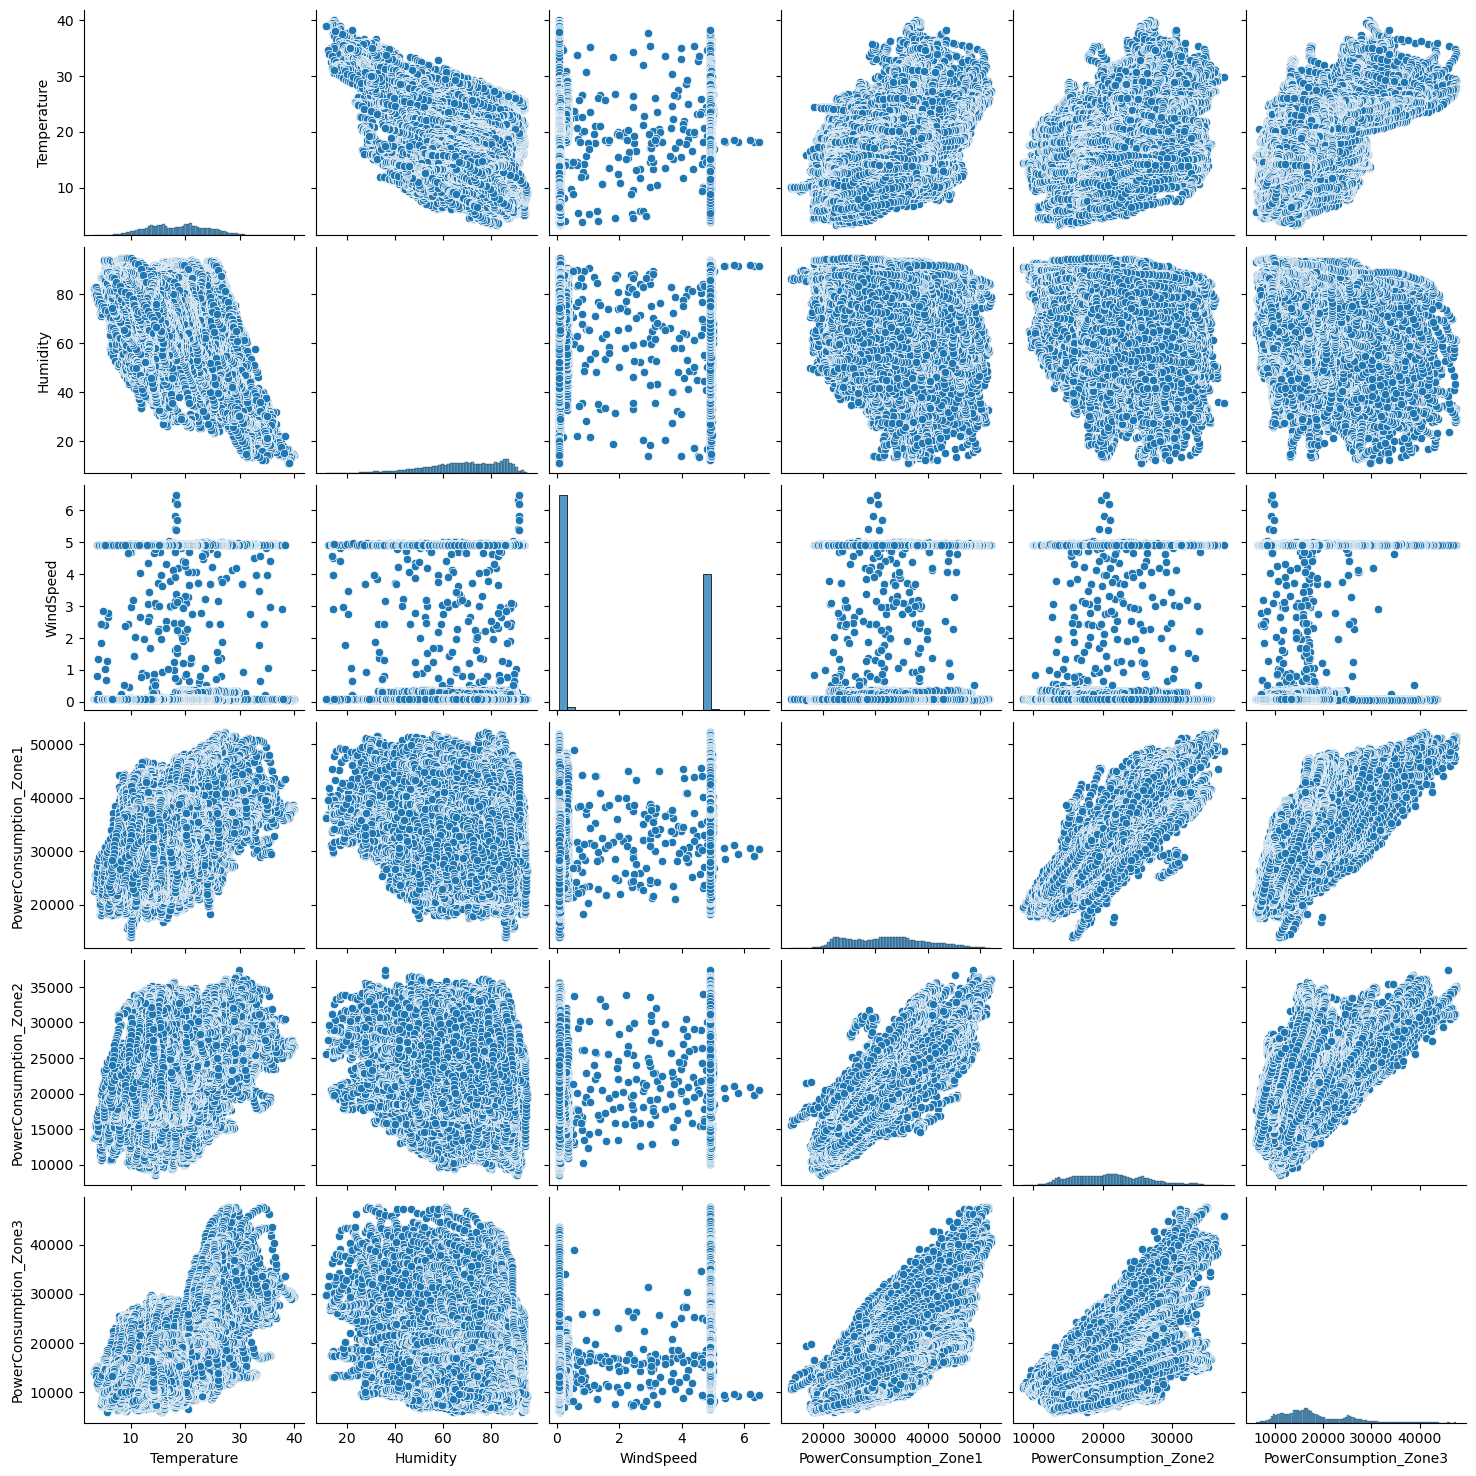

In [4]:
#Data Visualization
# Pairplot to visualize relationships between numerical columns
sns.pairplot(df[['Temperature', 'Humidity', 'WindSpeed', 'PowerConsumption_Zone1', 'PowerConsumption_Zone2', 'PowerConsumption_Zone3']])
plt.show()


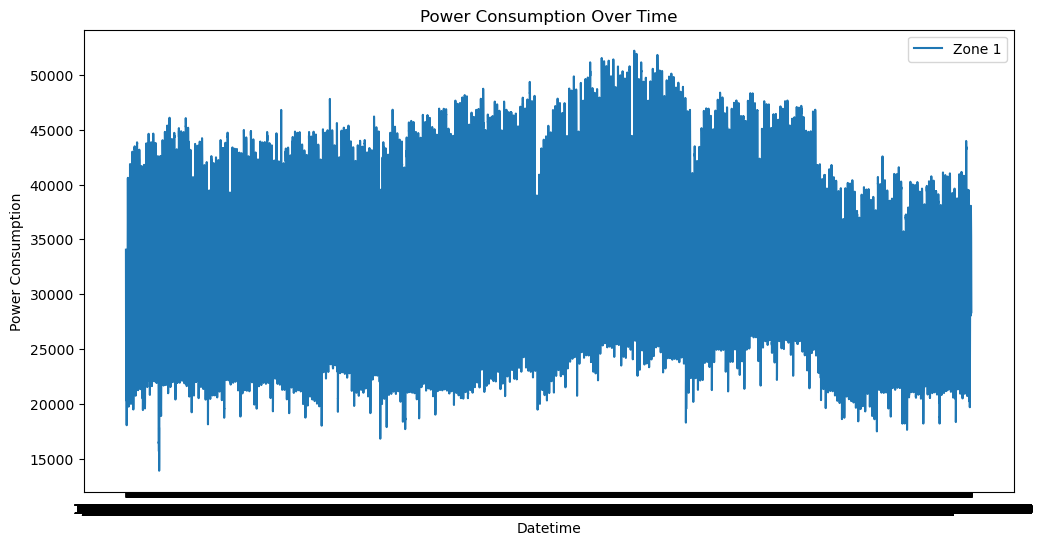

In [5]:
# Time series plot for PowerConsumption
plt.figure(figsize=(12, 6))
sns.lineplot(x='Datetime', y='PowerConsumption_Zone1', data=df, label='Zone 1')
plt.xlabel('Datetime')
plt.ylabel('Power Consumption')
plt.title('Power Consumption Over Time')
plt.show()

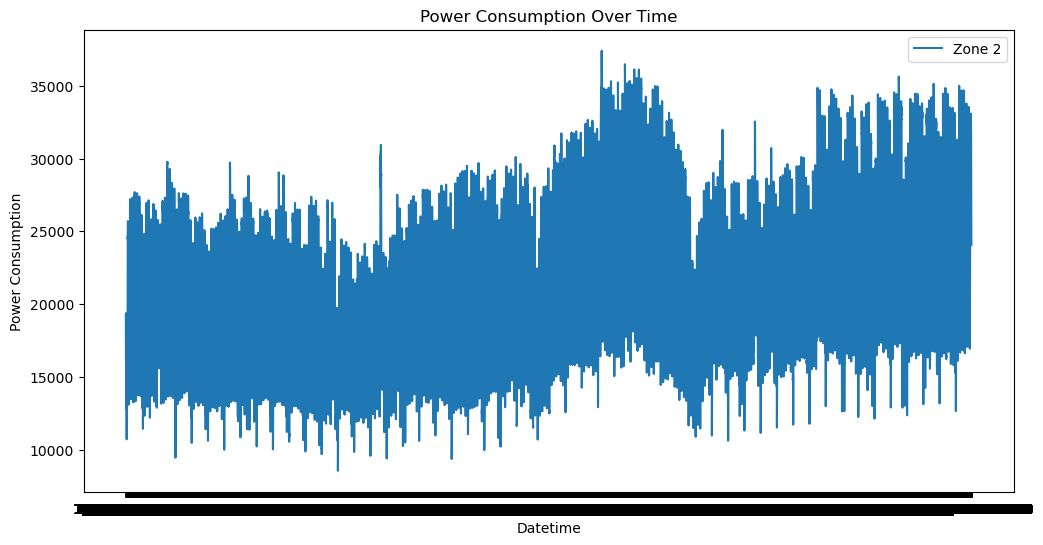

In [7]:
# Time series plot for PowerConsumption
plt.figure(figsize=(12, 6))
sns.lineplot(x='Datetime', y='PowerConsumption_Zone2', data=df, label='Zone 2')
plt.xlabel('Datetime')
plt.ylabel('Power Consumption')
plt.title('Power Consumption Over Time')
plt.show()

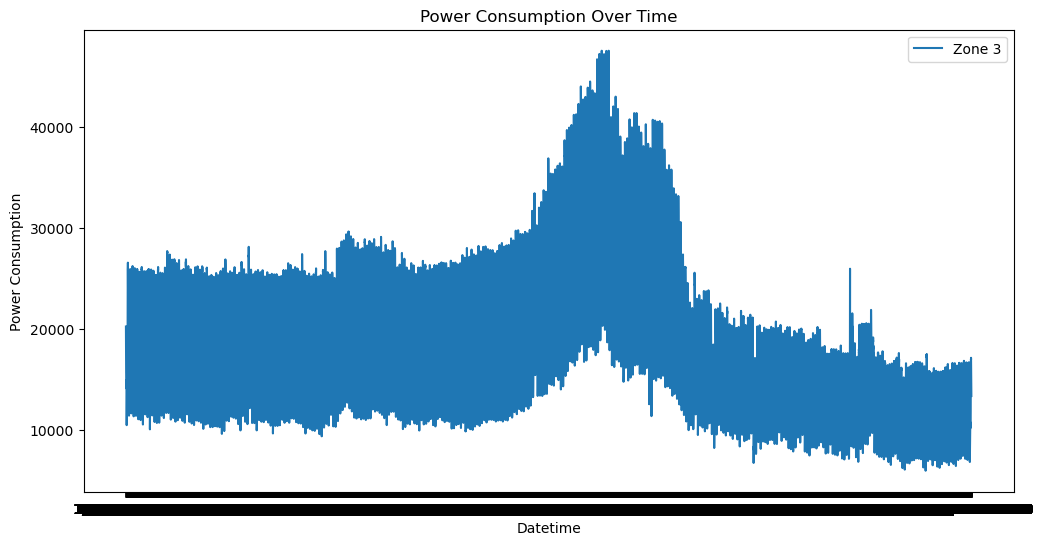

In [8]:
# Time series plot for PowerConsumption
plt.figure(figsize=(12, 6))
sns.lineplot(x='Datetime', y='PowerConsumption_Zone3', data=df, label='Zone 3')
plt.xlabel('Datetime')
plt.ylabel('Power Consumption')
plt.title('Power Consumption Over Time')
plt.show()

<a id='3'></a>
# <p style="background-color:skyblue; font-family:newtimeroman; font-size:150%; text-align:center">III. Data Preprocessing ⚙️</p>

## Chronological Order and Equidistant Timestamps

The data should be in chronological order and the timestamps should be equidistant in time series. The chronological order can be achieved by sorting the dataframe by the timestamps. Equidisant timestamps indicates constant time intervals. To check this, the difference between each timestamp can be taken. If this is not the case, you can decide on a constant time interval and resample the data.

But, first of all, lets see how to check if our dataset is correctly formated!

In [9]:
df['Datetime']=pd.to_datetime(df.Datetime)
df.sort_values(by='Datetime', ascending=True, inplace=True)

chronological_order = df['Datetime'].is_monotonic_increasing

time_diffs = df['Datetime'].diff()
equidistant_timestamps = time_diffs.nunique() == 1

In [10]:
chronological_order, equidistant_timestamps

(True, True)

This is already the case in our data: The time interval is 10 minutes and the data is already in chronological order. Therefore, we do not have to do this additional data preparation step.

<a id='3.1'></a>
## <p style="background-color:skyblue; font-family:newtimeroman; font-size:120%; text-align:center">III.1 Handle Missings</p>


We can see that the dataset doesn't have any missing values.

In [11]:
df.isna().sum()

Datetime                  0
Temperature               0
Humidity                  0
WindSpeed                 0
GeneralDiffuseFlows       0
DiffuseFlows              0
PowerConsumption_Zone1    0
PowerConsumption_Zone2    0
PowerConsumption_Zone3    0
dtype: int64

<a id='4'></a>
# <p style="background-color:skyblue; font-family:newtimeroman; font-size:150%; text-align:center">IV. Feature engineering 🔧</p>

In [12]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['minute'] = df.index.minute
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['day'] = df.index.month
    df['year'] = df.index.year
    df['season'] = df['month'] % 12 // 3 + 1
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    
    # Additional features
    df['is_weekend'] = df['dayofweek'].isin([5, 6]).astype(int)
    df['is_month_start'] = (df['dayofmonth'] == 1).astype(int)
    df['is_month_end'] = (df['dayofmonth'] == df.index.days_in_month).astype(int)
    df['is_quarter_start'] = (df['dayofmonth'] == 1) & (df['month'] % 3 == 1).astype(int)
    df['is_quarter_end'] = (df['dayofmonth'] == df.groupby(['year', 'quarter'])['dayofmonth'].transform('max'))
    
    # Additional features
    df['is_working_day'] = df['dayofweek'].isin([0, 1, 2, 3, 4]).astype(int)
    df['is_business_hours'] = df['hour'].between(9, 17).astype(int)
    df['is_peak_hour'] = df['hour'].isin([8, 12, 18]).astype(int)
    
    # Minute-level features
    df['minute_of_day'] = df['hour'] * 60 + df['minute']
    df['minute_of_week'] = (df['dayofweek'] * 24 * 60) + df['minute_of_day']
    
    return df.astype(float)

In [13]:
df = df.set_index('Datetime')
df = create_features(df)

In [14]:
df[[ 'year', 'month', 'day','minute', 'dayofyear', 'weekofyear', 'quarter', 'season']].head()

,year,month,day,minute,dayofyear,weekofyear,quarter,season
Datetime,,,,,,,,
2017-01-01 00:00:00,2017.0,1.0,1.0,0.0,1.0,52.0,1.0,1.0
2017-01-01 00:10:00,2017.0,1.0,1.0,10.0,1.0,52.0,1.0,1.0
2017-01-01 00:20:00,2017.0,1.0,1.0,20.0,1.0,52.0,1.0,1.0
2017-01-01 00:30:00,2017.0,1.0,1.0,30.0,1.0,52.0,1.0,1.0
2017-01-01 00:40:00,2017.0,1.0,1.0,40.0,1.0,52.0,1.0,1.0


<a id='4'></a>
# <p style="background-color:skyblue; font-family:newtimeroman; font-size:150%; text-align:center">V. Exploratory Data Analysis 📊</p>

Now, we are going to plot the data and try to extract some knowledge.

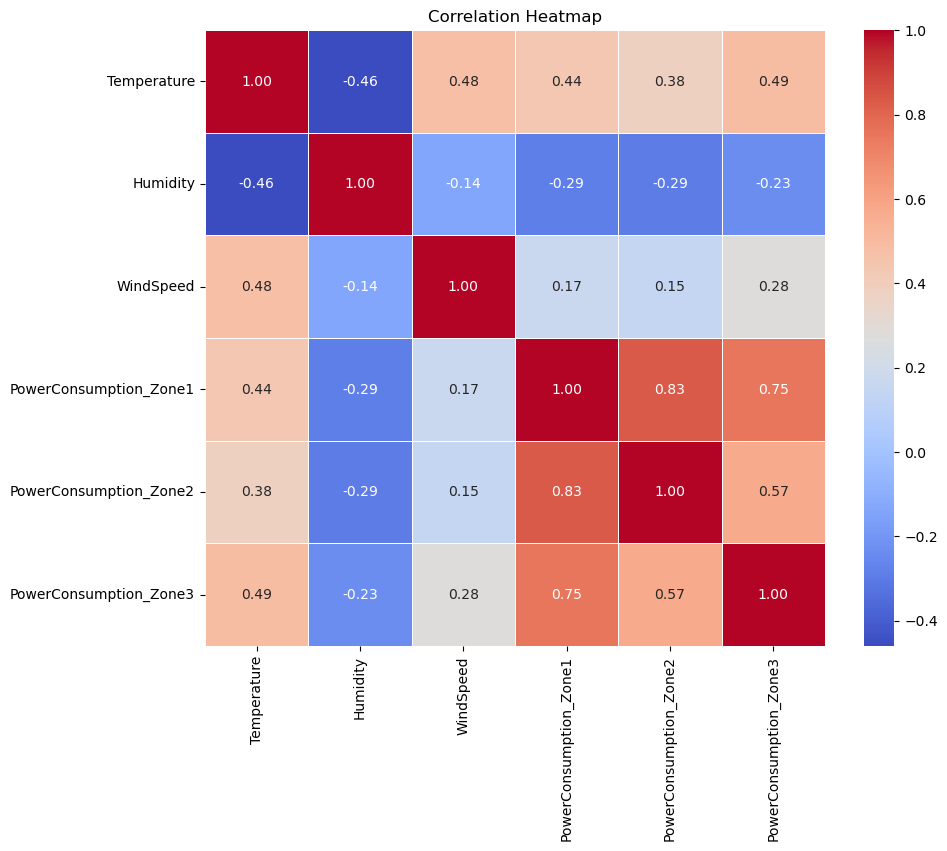

In [15]:
# Calculate correlation matrix
correlation_matrix = df[['Temperature', 'Humidity', 'WindSpeed', 'PowerConsumption_Zone1', 'PowerConsumption_Zone2', 'PowerConsumption_Zone3']].corr()

# Create a heatmap of the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

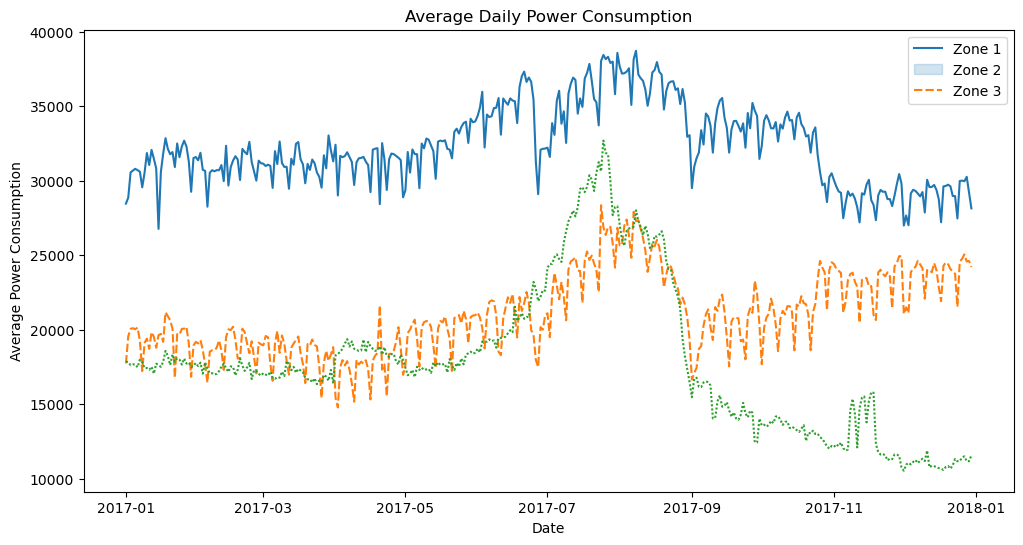

In [16]:
# Resample the data for more meaningful time series analysis (e.g., daily, weekly)
daily_resampled = df.resample('D').mean()

# Plot daily Power Consumption for each zone
plt.figure(figsize=(12, 6))
sns.lineplot(data=daily_resampled[['PowerConsumption_Zone1', 'PowerConsumption_Zone2', 'PowerConsumption_Zone3']])
plt.xlabel('Date')
plt.ylabel('Average Power Consumption')
plt.title('Average Daily Power Consumption')
plt.legend(labels=['Zone 1', 'Zone 2', 'Zone 3'])
plt.show()


<a id='6'></a>
# <p style="background-color:skyblue; font-family:newtimeroman; font-size:150%; text-align:center">VI. Modeling 🧩</p> 

In [17]:
from sklearn.preprocessing import StandardScaler

# Separate the input features (X) and target variables (y)
X = df.drop(['PowerConsumption_Zone1', 'PowerConsumption_Zone2', 'PowerConsumption_Zone3'], axis=1)
y = df[['PowerConsumption_Zone1', 'PowerConsumption_Zone2', 'PowerConsumption_Zone3']]

# Initialize StandardScaler for y
scaler_y = StandardScaler()

# Fit and transform  y
y_scaled = scaler_y.fit_transform(y)

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y_scaled, test_size=0.25, shuffle=False)

<a id='6.1'></a>
## <p style="background-color:skyblue; font-family:newtimeroman; font-size:100%; text-align:center">VI.1. Multilayer Perceptron model</p>


In [19]:
epochs = 40
batch = 256
lr = 0.0003
adam = optimizers.Adam(lr)

In [20]:
model_mlp = Sequential()
model_mlp.add(Dense(100, activation='relu', input_dim=X_train.shape[1]))
model_mlp.add(Dense(3))
model_mlp.compile(loss='mse', optimizer=adam)
model_mlp.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100)               2700      
                                                                 
 dense_1 (Dense)             (None, 3)                 303       
                                                                 
Total params: 3,003
Trainable params: 3,003
Non-trainable params: 0
_________________________________________________________________


In [21]:
mlp_history = model_mlp.fit(X_train.values, y_train, validation_data=(X_test.values, y_test), epochs=epochs, verbose=2)

Epoch 1/40
1229/1229 - 5s - loss: 1704.6450 - val_loss: 71.4972 - 5s/epoch - 4ms/step
Epoch 2/40
1229/1229 - 3s - loss: 27.1603 - val_loss: 21.5580 - 3s/epoch - 2ms/step
Epoch 3/40
1229/1229 - 3s - loss: 12.3309 - val_loss: 11.4385 - 3s/epoch - 2ms/step
Epoch 4/40
1229/1229 - 3s - loss: 6.2658 - val_loss: 7.7198 - 3s/epoch - 2ms/step
Epoch 5/40
1229/1229 - 3s - loss: 3.8242 - val_loss: 6.9785 - 3s/epoch - 2ms/step
Epoch 6/40
1229/1229 - 3s - loss: 2.8325 - val_loss: 5.4403 - 3s/epoch - 2ms/step
Epoch 7/40
1229/1229 - 3s - loss: 2.1864 - val_loss: 4.5518 - 3s/epoch - 2ms/step
Epoch 8/40
1229/1229 - 3s - loss: 2.1841 - val_loss: 2.8193 - 3s/epoch - 2ms/step
Epoch 9/40
1229/1229 - 3s - loss: 1.8881 - val_loss: 3.1349 - 3s/epoch - 2ms/step
Epoch 10/40
1229/1229 - 3s - loss: 1.8433 - val_loss: 2.6564 - 3s/epoch - 2ms/step
Epoch 11/40
1229/1229 - 3s - loss: 1.6761 - val_loss: 4.6073 - 3s/epoch - 2ms/step
Epoch 12/40
1229/1229 - 3s - loss: 1.7782 - val_loss: 4.2521 - 3s/epoch - 2ms/step
Epoch

In [22]:
train_predict = model_mlp.predict(X_train)
test_predict = model_mlp.predict(X_test)


# Calculate MSE and MAE as you already did
mse = mean_squared_error(y_test, test_predict)
mae = mean_absolute_error(y_test, test_predict)

# Print the results
print("Mean squared error on test set: {:.4f}".format(mse))
print("Mean absolute error on test set: {:.4f}".format(mae))


410/410 [==============================] - 1s 1ms/step
Mean squared error on test set: 2.9596
Mean absolute error on test set: 1.4522


<a id='6.2'></a>
## <p style="background-color:skyblue; font-family:newtimeroman; font-size:100%; text-align:center">VI.2. CNN Model</p>

In [23]:
X_train_series = X_train.values.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test_series = X_test.values.reshape((X_test.shape[0], X_test.shape[1], 1))
print('Train set shape', X_train_series.shape)
print('Validation set shape', X_test_series.shape)

Train set shape (39312, 26, 1)
Validation set shape (13104, 26, 1)


In [24]:
model_cnn = Sequential()
model_cnn.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(X_train_series.shape[1], X_train_series.shape[2])))
model_cnn.add(MaxPooling1D(pool_size=2))
model_cnn.add(Flatten())
model_cnn.add(Dense(50, activation='relu'))
model_cnn.add(Dense(3))
model_cnn.compile(loss='mse', optimizer=adam)
model_cnn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 25, 64)            192       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 12, 64)           0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 768)               0         
                                                                 
 dense_2 (Dense)             (None, 50)                38450     
                                                                 
 dense_3 (Dense)             (None, 3)                 153       
                                                                 
Total params: 38,795
Trainable params: 38,795
Non-trainable params: 0
__________________________________________________

In [25]:
cnn_history = model_cnn.fit(X_train_series, y_train, validation_data=(X_test_series, y_test), epochs=epochs, verbose=2)

Epoch 1/40
1229/1229 - 5s - loss: 27.8756 - val_loss: 1.5566 - 5s/epoch - 4ms/step
Epoch 2/40
1229/1229 - 3s - loss: 0.5039 - val_loss: 1.1152 - 3s/epoch - 3ms/step
Epoch 3/40
1229/1229 - 3s - loss: 0.4888 - val_loss: 1.1869 - 3s/epoch - 3ms/step
Epoch 4/40
1229/1229 - 3s - loss: 0.4978 - val_loss: 0.9263 - 3s/epoch - 3ms/step
Epoch 5/40
1229/1229 - 3s - loss: 0.5276 - val_loss: 0.8750 - 3s/epoch - 3ms/step
Epoch 6/40
1229/1229 - 3s - loss: 0.5398 - val_loss: 0.8642 - 3s/epoch - 3ms/step
Epoch 7/40
1229/1229 - 3s - loss: 0.5449 - val_loss: 0.4256 - 3s/epoch - 3ms/step
Epoch 8/40
1229/1229 - 3s - loss: 0.4935 - val_loss: 0.8461 - 3s/epoch - 3ms/step
Epoch 9/40
1229/1229 - 3s - loss: 0.5102 - val_loss: 0.4392 - 3s/epoch - 3ms/step
Epoch 10/40
1229/1229 - 3s - loss: 0.4986 - val_loss: 0.6087 - 3s/epoch - 3ms/step
Epoch 11/40
1229/1229 - 3s - loss: 0.4923 - val_loss: 0.4867 - 3s/epoch - 3ms/step
Epoch 12/40
1229/1229 - 3s - loss: 0.4683 - val_loss: 0.5279 - 3s/epoch - 3ms/step
Epoch 13/40


In [26]:
train_predict = model_cnn.predict(X_train)
test_predict = model_cnn.predict(X_test)


# Calculate MSE and MAE as you already did
mse = mean_squared_error(y_test, test_predict)
mae = mean_absolute_error(y_test, test_predict)

# Print the results
print("Mean squared error on test set: {:.4f}".format(mse))
print("Mean absolute error on test set: {:.4f}".format(mae))


410/410 [==============================] - 1s 1ms/step
Mean squared error on test set: 2.4821
Mean absolute error on test set: 1.2249


<a id='6.3'></a>
## <p style="background-color:skyblue; font-family:newtimeroman; font-size:100%; text-align:center">VI.3. LSTM Model</p>

In [27]:
model_lstm = Sequential()
model_lstm.add(LSTM(50, activation='relu', input_shape=(X_train_series.shape[1], X_train_series.shape[2])))
model_lstm.add(Dense(3))
model_lstm.compile(loss='mse', optimizer=adam)
model_lstm.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50)                10400     
                                                                 
 dense_4 (Dense)             (None, 3)                 153       
                                                                 
Total params: 10,553
Trainable params: 10,553
Non-trainable params: 0
_________________________________________________________________


In [28]:
lstm_history = model_lstm.fit(X_train_series, y_train, validation_data=(X_test_series, y_test), epochs=epochs, verbose=2)

Epoch 1/40
1229/1229 - 43s - loss: 138.6666 - val_loss: 9.5792 - 43s/epoch - 35ms/step
Epoch 2/40
1229/1229 - 42s - loss: 0.3132 - val_loss: 10.7090 - 42s/epoch - 35ms/step
Epoch 3/40
1229/1229 - 42s - loss: 0.2121 - val_loss: 12.3179 - 42s/epoch - 34ms/step
Epoch 4/40
1229/1229 - 42s - loss: 0.1938 - val_loss: 13.6392 - 42s/epoch - 34ms/step
Epoch 5/40
1229/1229 - 42s - loss: 0.1857 - val_loss: 9.6221 - 42s/epoch - 35ms/step
Epoch 6/40
1229/1229 - 42s - loss: 0.1647 - val_loss: 9.2022 - 42s/epoch - 34ms/step
Epoch 7/40
1229/1229 - 43s - loss: 0.1604 - val_loss: 6.4702 - 43s/epoch - 35ms/step
Epoch 8/40
1229/1229 - 43s - loss: 0.1350 - val_loss: 6.5193 - 43s/epoch - 35ms/step
Epoch 9/40
1229/1229 - 42s - loss: 0.1348 - val_loss: 7.0706 - 42s/epoch - 35ms/step
Epoch 10/40
1229/1229 - 42s - loss: 0.1319 - val_loss: 7.3706 - 42s/epoch - 34ms/step
Epoch 11/40
1229/1229 - 43s - loss: 0.1147 - val_loss: 7.6928 - 43s/epoch - 35ms/step
Epoch 12/40
1229/1229 - 42s - loss: 0.1155 - val_loss: 5.0

In [29]:
train_predict = model_lstm.predict(X_train)
test_predict = model_lstm.predict(X_test)


# Calculate MSE and MAE as you already did
mse = mean_squared_error(y_test, test_predict)
mae = mean_absolute_error(y_test, test_predict)

# Print the results
print("Mean squared error on test set: {:.4f}".format(mse))
print("Mean absolute error on test set: {:.4f}".format(mae))


410/410 [==============================] - 2s 5ms/step
Mean squared error on test set: 0.6077
Mean absolute error on test set: 0.5633


<a id='6.4'></a>
## <p style="background-color:skyblue; font-family:newtimeroman; font-size:100%; text-align:center">VI.4. Xgboost model</p>

In [ ]:
# Define the hyperparameter grid for XGBoost
param_grid = {
    'objective':['reg:squarederror'],
    'max_depth': [2, 5, 7],
    'learning_rate': [0.1, 0.01, 0.001],
    'subsample': [0.5, 0.7],
    'n_estimators': [1000,1500,2000],
    'min_child_weight': [1, 2],
    'booster':['gbtree']
}

# Create the XGBoost model object
xgb_model = xgb.XGBRegressor(tree_method='gpu_hist')


# Create the GridSearchCV 
grid_search = GridSearchCV(xgb_model, param_grid, cv=7, scoring='neg_mean_squared_error')

# Fit the GridSearchCV object to the training data
grid_search.fit(X_train, y_train)

# Print the best set of hyperparameters and the corresponding score
print("Best set of hyperparameters: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)

# Evaluate the model on the test set
y_pred = grid_search.best_estimator_.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print("Mean squared error on test set: ", mse)
print("Mean absolute error on test set: ", mae)

In [ ]:
model =  grid_search.best_estimator_
# model = xgb.XGBRegressor(booster='gbtree', learning_rate=0.1, 
#                          max_depth=7, min_child_weight=2, n_estimators=1000, 
#                          objective='reg:squarederror', subsample= 0.8)

In [ ]:
xgboost_history = model.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
       verbose=200)

In [ ]:
# Lets predict with the model
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)


mse = mean_squared_error(y_test, test_predict)
mae = mean_absolute_error(y_test, test_predict)
print("Mean squared error on test set: ", mse)
print("Mean absolute error on test set: ", mae)

In [ ]:
# Feature Importances
_ = plot_importance(model, height=0.9)

<a id='6.5'></a>
## <p style="background-color:skyblue; font-family:newtimeroman; font-size:100%; text-align:center">VI.5. Comparing models</p>

In [ ]:
fig, axes = plt.subplots(2, 2, sharex=True, sharey=True,figsize=(22,12))
ax1, ax2 = axes[0]
ax3, ax4 = axes[1]

ax1.plot(mlp_history.history['loss'], label='Train loss')
ax1.plot(mlp_history.history['val_loss'], label='Validation loss')
ax1.legend(loc='best')
ax1.set_title('MLP')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('MSE')

ax2.plot(cnn_history.history['loss'], label='Train loss')
ax2.plot(cnn_history.history['val_loss'], label='Validation loss')
ax2.legend(loc='best')
ax2.set_title('CNN')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('MSE')

ax3.plot(lstm_history.history['loss'], label='Train loss')
ax3.plot(lstm_history.history['val_loss'], label='Validation loss')
ax3.legend(loc='best')
ax3.set_title('LSTM')
ax3.set_xlabel('Epochs')
ax3.set_ylabel('MSE')

# ax3.plot(xgboost_history.history['loss'], label='Train loss')
# ax3.plot(xgboost_history.history['val_loss'], label='Validation loss')
# ax3.legend(loc='best')
# ax3.set_title('Xgboost')
# ax3.set_xlabel('Epochs')
# ax3.set_ylabel('MSE')
plt.show()

<a id='6'></a>
# <p style="background-color:skyblue; font-family:newtimeroman; font-size:150%; text-align:center">VII. Conclusions 💎</p>

The best results are taken from Xgboost.

<a id='7'></a>
# <p style="background-color:skyblue; font-family:newtimeroman; font-size:150%; text-align:center">VIII. References 📝</p>

Here I am going to reference some useful links that I have used to build this notebook

* Special reference for the helpful information and plots - https://www.kaggle.com/iamleonie/intro-to-time-series-forecasting
* Special reference - https://www.kaggle.com/code/azminetoushikwasi/time-series-analysis-forecasting
* Keras LSTM - https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/
* Special reference - https://www.kaggle.com/code/dimitreoliveira/deep-learning-for-time-series-forecasting
